In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import logging
import scipy.stats as sts
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
from arch import arch_model

In [3]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from antecedent_fitting import fit_antecedent_params
from local_models import calculate_retraining_garch_forecasts

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
files_folder = config['files_folders']['processed']
research_results_folder = config['files_folders']['research_results']
antecedent_params_folder = config['files_folders']['antecedent_params_sets']
metadata_file_name = 'current_antecedent_fitting_metadata.pkl'

# Reading data

In [6]:
with open(f'{antecedent_params_folder}/{metadata_file_name}', 'rb') as file:
    data = pickle.load(file)

In [7]:
train = data['train']
test = data['test']
consequent_metaparams = data['consequent_metaparams']
consequent_params_ini = data['consequent_params_ini']
antecedent_params_set = data['antecedent_params_set']
clusterization_method = data['clusterization_method']
local_method = data['local_method']
data_to_cluster_train = data['data_to_cluster_train']
data_to_cluster_test = data['data_to_cluster_test']

In [8]:
p = consequent_metaparams['p']
q = consequent_metaparams['q']

n_train = train.shape[0]
n_test = test.shape[0]

# Main input data plot

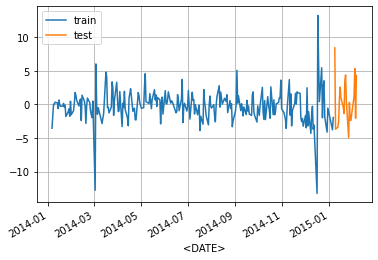

In [9]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

## train & test sizes

In [10]:
print(train.shape[0], test.shape[0])

252 21


# Antecedent params set

In [11]:
# antecedent_params_set = antecedent_params_set[1930:2054]

In [12]:
# for _antecedent_params in antecedent_params_set:
#     _centers = _antecedent_params['centers']
#     _variances = _antecedent_params['variances']
#     _n_clusters = _antecedent_params['n_clusters']
    
#     for i in range(_n_clusters):
#         _range = np.arange(-20, 20, .01)
#         _data = sts.norm(_centers[i], _variances[i] ** .5).pdf(_range)

#         plt.plot(_range, _data, label=f'cluster #{i + 1}')
    
#     plt.title(_antecedent_params)
#     plt.legend()
#     plt.grid()
#     plt.show()

# Fitting

In [13]:
result = None

In [14]:
logging.basicConfig(level=logging.INFO)

In [15]:
train.iloc[:5]

<DATE>
2014-01-06   -3.552256
2014-01-08    0.018679
2014-01-09   -0.010776
2014-01-10    0.317039
2014-01-13    0.226762
Name: log return, dtype: float64

In [16]:
%%time

result = fit_antecedent_params(train, test,
                               consequent_metaparams=consequent_metaparams,
                               consequent_params_ini=consequent_params_ini,
                               antecedent_params_set=antecedent_params_set,
                               clusterization_method=clusterization_method,
                               local_method=local_method,
                               data_to_cluster_train='train', data_to_cluster_test=None)

INFO:fit_antecedent_params:Starting iteration #0
INFO:model.model:Creating an instance of FuzzyVolatilityModel
INFO:fit_antecedent_params:Iteration #0 ended


CPU times: user 16min 2s, sys: 16.9 s, total: 16min 19s
Wall time: 10min 12s


# Adding some info

In [17]:
result['train'] = train
result['test'] = test
result['antecedent_params_set'] = antecedent_params_set
result['consequent_metaparams'] = consequent_metaparams
result['consequent_params_ini'] = consequent_params_ini
result['clusterization_method'] = clusterization_method
result['local_method'] = local_method
result['data_to_cluster_train'] = data_to_cluster_train
result['data_to_cluster_test'] = data_to_cluster_test

## Vanilla GARCH errors

### No retraining

In [18]:
garch_mean = 'Zero'
garch_dist = 'normal'
garch_vol = 'GARCH'

garch = arch_model(train,
                   mean=garch_mean,
                   vol=garch_vol,
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1092.0427023331195
Iteration:      2,   Func. Count:     12,   Neg. LLF: 603.1666186903681
Iteration:      3,   Func. Count:     17,   Neg. LLF: 563.3283151050689
Iteration:      4,   Func. Count:     22,   Neg. LLF: 546.3505376444025
Iteration:      5,   Func. Count:     26,   Neg. LLF: 546.3032223117447
Iteration:      6,   Func. Count:     30,   Neg. LLF: 546.2982785222438
Iteration:      7,   Func. Count:     34,   Neg. LLF: 546.2979077243597
Iteration:      8,   Func. Count:     38,   Neg. LLF: 546.29790526342
Iteration:      9,   Func. Count:     41,   Neg. LLF: 546.2979052633018
Optimization terminated successfully    (Exit mode 0)
            Current function value: 546.29790526342
            Iterations: 9
            Function evaluations: 41
            Gradient evaluations: 9


In [19]:
simple_garch_forecasts = garch_fitted.forecast(horizon=n_test, reindex=False).variance.iloc[0].values

In [20]:
mse = mean_squared_error(simple_garch_forecasts, test ** 2, squared=True)
rmse = mean_squared_error(simple_garch_forecasts, test ** 2, squared=False)
mape = mean_absolute_percentage_error(simple_garch_forecasts, test ** 2)

garch_errors = {'mse': mse, 'rmse': rmse, 'mape': mape}
garch_errors

{'mse': 273.5785179694508,
 'rmse': 16.540209127137746,
 'mape': 1.63195068518617}

In [33]:
result['Vanilla GARCH n/r errors'] = garch_errors

### W/ retraining

In [22]:
retraining_garch_forecasts = calculate_retraining_garch_forecasts(train, test,
                                                                  mean=garch_mean,
                                                                  vol=garch_vol,
                                                                  p=p,
                                                                  q=q,
                                                                  dist=garch_dist)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1069.9367402615442
Iteration:      2,   Func. Count:     11,   Neg. LLF: 607.5653592305116
Iteration:      3,   Func. Count:     17,   Neg. LLF: 554.9131181705276
Iteration:      4,   Func. Count:     22,   Neg. LLF: 594.7637422323328
Iteration:      5,   Func. Count:     27,   Neg. LLF: 553.180782798813
Iteration:      6,   Func. Count:     31,   Neg. LLF: 553.1802313393547
Iteration:      7,   Func. Count:     35,   Neg. LLF: 553.1800192181163
Iteration:      8,   Func. Count:     39,   Neg. LLF: 553.180015478363
Iteration:      9,   Func. Count:     42,   Neg. LLF: 553.1800154782134
Optimization terminated successfully    (Exit mode 0)
            Current function value: 553.180015478363
            Iterations: 9
            Function evaluations: 42
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1068.4892511122791
Iteration:      2,   Func. Count:     11,   Neg. LLF: 611.0175194769245
It

In [23]:
_mse = mean_squared_error(retraining_garch_forecasts, test ** 2, squared=True)
_rmse = mean_squared_error(retraining_garch_forecasts, test ** 2, squared=False)
_mape = mean_absolute_percentage_error(retraining_garch_forecasts, test ** 2)

retr_garch_errors = {'mse': _mse, 'rmse': _rmse, 'mape': _mape}
retr_garch_errors

{'mse': 179.09007568016176,
 'rmse': 13.382454023091645,
 'mape': 0.8568925530906597}

In [35]:
result['Vanilla GARCH w/r errors'] = retr_garch_errors

# Dumping

## into a single file

In [25]:
cur_time = str(pd.Timestamp.today().floor('s')).replace(':', '-')
print(cur_time)

with open(f'{research_results_folder}/fitting_consequent_params_result_{cur_time}.pkl', 'wb') as file:
    pickle.dump(result, file)

2022-02-19 18-23-14


## into a table

In [26]:
# summary = pd.DataFrame(columns=['Time',
#                                 'p', 'q',
#                                 'Start date', 'Train size', 'Test size',
#                                 '# clusters', 'Centers', 'Variances',
#                                 'MSE', 'Vanilla GARCH MSE (no retraining)', 'Vanilla GARCH MSE (w/ retraining)'])

In [27]:
summary_pkl_loc = f'{research_results_folder}/summary_table.pkl'

summary = pd.read_pickle(summary_pkl_loc)

new_entries = []

_garch_nr_mse = result['Vanilla GARCH n/r errors']['mse']
_garch_wr_mse = result['Vanilla GARCH w/r errors']['mse']

for i in range(len(result['fvms'])):
    _antecedent_params = result['antecedent_params_set'][i]
    _centers = _antecedent_params['centers']
    _vars = _antecedent_params['variances']
    _n_clusters = _antecedent_params['n_clusters']
    
    _mse = result['mses'][i]
    
    new_entry = {
        'Time': cur_time,
        'p': p,
        'q': q,
        'Start date': train.index.min(),
        'Train size': n_train,
        'Test size': n_test,
        '# clusters': _n_clusters,
        'Centers': _centers,
        'Variances': _vars,
        'MSE': _mse,
        'Vanilla GARCH MSE (no retraining)': _garch_nr_mse,
        'Vanilla GARCH MSE (w/ retraining)': _garch_wr_mse
    }
    
    new_entries.append(new_entry)

summary = summary.append(new_entries, ignore_index=True, verify_integrity=False, sort=False).copy()

summary.to_pickle(f'{research_results_folder}/summary_table.pkl')
summary.to_excel(f'{research_results_folder}/summary_table.xlsx')

In [28]:
# _ini = pd.read_excel(f'files/summary_table_ini_2022-02-05.xlsx')

# Looking at results

In [29]:
fvms = result['fvms']

In [30]:
result['mses']

[353.14298360549203953]

NameError: name 'input_cut' is not defined

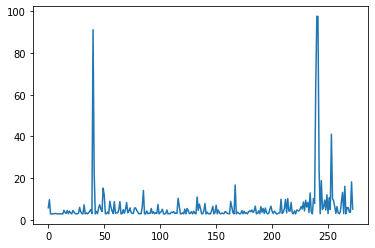

In [31]:
plt.plot(fvms[0].h[:-1], label='forecast')
plt.plot(input_cut.values ** 2, label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
(fvms[0].hist_output ** .5).plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts ** .5, index=fvms[0].hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
fvms[0].hist_output.plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts, index=fvms[0].hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
(input_cut ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()